In [1]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs --break-system-packages
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO --break-system-packages

In [2]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO

 # please re-start kernel if these packages are installed for the first time

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
import datetime
import concurrent
from phantasy import caget

In [4]:
import objFuncs
from objFuncs import maximize_FC
from objFuncs.util import get_MEBT_objective_goal_from_BPMoverview
from objFuncs.util import plot_obj_history
from pyBO import pyBO

objFuncs version: 1.0.1. updated on 2023-12-14
pyBO version: 1.0.0. updated on 2023-12-14


In [5]:
n_init = 50
n_local_search = 5
n_budget = 120

# check objFuncs machineIO, source and beam  

In [6]:
objFuncs._global_machineIO._test = False
objFuncs._global_machineIO._fetch_data_time_span = 1.0
objFuncs._global_machineIO._ensure_set_timewait_after_ramp : 0.25
objFuncs._global_machineIO.view()

   _test : True
   _ensure_set_timeout : 30
   _ensure_set_timewait_after_ramp : 0.25
   _fetch_data_time_span : 1.0
   _return_obj_var : False
   _check_chopper_blocking : True
   _n_popup_ramping_not_OK : 0
   _verbose : False


In [7]:
SCS = caget("ACS_DIAG:DEST:ACTIVE_ION_SOURCE")
ion = caget("FE_ISRC"+str(SCS)+":BEAM:ELMT_BOOK")
Q = caget("FE_ISRC"+str(SCS)+":BEAM:Q_BOOK")
A = caget("FE_ISRC"+str(SCS)+":BEAM:A_BOOK")
# AQ = caget("FE_ISRC2:BEAM:MOVRQ_BOOK")
AQ = A/Q
ion = str(A)+ion+str(Q)
print('SCS'+str(SCS), ion, 'A/Q=',AQ)

SCS2 238U35 A/Q= 6.8


In [8]:
now0 = datetime.datetime.now()
now0str = now0.strftime('%Y%m%d_%H%M')
fname = now0str+'['+ion+'][pyBO_TR][MEBT]FC1102'
fname

'20231218_2134[238U35][pyBO_TR][MEBT]FC1102'

# preprare objective

In [9]:
decision_CSETs=[
                 'FE_LEBT:PSC2_D0948:I_CSET', 'FE_LEBT:PSC1_D0948:I_CSET',
                 'FE_LEBT:PSC2_D0964:I_CSET', 'FE_LEBT:PSC1_D0964:I_CSET',
                 'FE_LEBT:PSC2_D0979:I_CSET', 'FE_LEBT:PSC1_D0979:I_CSET',
                 'FE_LEBT:PSC2_D0992:I_CSET', 'FE_LEBT:PSC1_D0992:I_CSET',
                 ]
# decision_min = [-0.4*AQ,-0.4*AQ,-0.5*AQ,-0.5*AQ, -0.5*AQ,-0.5*AQ]
# decision_max = [ 0.4*AQ, 0.4*AQ, 0.5*AQ, 0.5*AQ,  0.5*AQ, 0.5*AQ]
decision_min = [-0.3*AQ,-0.3*AQ,-0.3*AQ,-0.3*AQ, -0.2*AQ,-0.2*AQ, -0.1*AQ,-0.1*AQ]
decision_max = [ 0.3*AQ, 0.3*AQ, 0.3*AQ, 0.3*AQ,  0.2*AQ, 0.2*AQ,  0.1*AQ, 0.1*AQ]



# avoid polarity crossing of some correctors by choosing proper bounds

# decision_min = [-0.7*AQ,-0.7*AQ,-0.7*AQ,-0.7*AQ,      0,      0]
# decision_max = [ 0.7*AQ, 0.7*AQ, 0.7*AQ, 0.7*AQ, 0.2*AQ, 0.2*AQ]  

# decision_min = [      0,      0,-0.7*AQ,-0.7*AQ,-0.7*AQ,-0.7*AQ]
# decision_max = [ 0.2*AQ, 0.2*AQ, 0.7*AQ, 0.7*AQ, 0.7*AQ, 0.7*AQ]  

decision_max

[2.04, 2.04, 2.04, 2.04, 1.36, 1.36, 0.68, 0.68]

In [10]:
# FC814 = 22.2
FC998 = 30.0
FC998

30.0

In [11]:
BPM_snapshot_fname = '20230730_0235_48Ca10_2cs_216p7MeVu_100W_pulsed_BDSBD.bpm'
objective_goal = get_MEBT_objective_goal_from_BPMoverview(BPM_snapshot_fname)
objective_goal['FE_MEBT:FC_D1102:PKAVG_RD'] = {'more than': 0.8*FC998}
objective_goal

{'FE_MEBT:BPM_D1056:XPOS_RD': 0.15818255295506434,
 'FE_MEBT:BPM_D1056:YPOS_RD': -0.865992899215285,
 'FE_MEBT:BPM_D1056:PHASE_RD': 79.62596370962774,
 'FE_MEBT:BPM_D1056:MAG_RD': {'more than': None},
 'FE_MEBT:BPM_D1072:XPOS_RD': -0.03651407261179056,
 'FE_MEBT:BPM_D1072:YPOS_RD': 0.13124672537742332,
 'FE_MEBT:BPM_D1072:PHASE_RD': -25.17847557544062,
 'FE_MEBT:BPM_D1072:MAG_RD': {'more than': None},
 'FE_MEBT:BPM_D1094:XPOS_RD': 0.05986132622907858,
 'FE_MEBT:BPM_D1094:YPOS_RD': 0.008730118556052227,
 'FE_MEBT:BPM_D1094:PHASE_RD': -20.121876853861338,
 'FE_MEBT:BPM_D1094:MAG_RD': {'more than': None},
 'FE_MEBT:BCM_D1055:AVGPK_RD/FE_LEBT:BCM_D0989:AVGPK_RD': {'more than': 1.0},
 'FE_MEBT:FC_D1102:PKAVG_RD': {'more than': 24.0}}

In [12]:
objective_goal = {
    'FE_MEBT:BPM_D1056:XPOS_RD': 0,
    'FE_MEBT:BPM_D1056:YPOS_RD': 0,
    'FE_MEBT:BPM_D1056:PHASE_RD': 79.62596370962774,
    'FE_MEBT:BPM_D1056:MAG_RD': {'more than': None},
    'FE_MEBT:BPM_D1072:XPOS_RD': 0,
    'FE_MEBT:BPM_D1072:YPOS_RD': 0,
    'FE_MEBT:BPM_D1072:PHASE_RD': -25.17847557544062,
    'FE_MEBT:BPM_D1072:MAG_RD': {'more than': None},
    'FE_MEBT:BPM_D1094:XPOS_RD': 0,
    'FE_MEBT:BPM_D1094:YPOS_RD': 0,
    'FE_MEBT:BPM_D1094:PHASE_RD': -20.121876853861338,
    'FE_MEBT:BPM_D1094:MAG_RD': {'more than': None},
    'FE_MEBT:BCM_D1055:AVGPK_RD/FE_LEBT:BCM_D0989:AVGPK_RD': {'more than': 0.982},
    'FE_MEBT:FC_D1102:PKAVG_RD': {'more than': 0.8*FC998} #0.8*FC814
}

In [13]:
objective_norm = { 
    'FE_MEBT:BPM_D1056:XPOS_RD' : 1.,     
    'FE_MEBT:BPM_D1056:YPOS_RD' : 1.,     
    'FE_MEBT:BPM_D1056:PHASE_RD': 1., 
    'FE_MEBT:BPM_D1056:MAG_RD'  : 0, 
    'FE_MEBT:BPM_D1072:XPOS_RD' : 1.,     
    'FE_MEBT:BPM_D1072:YPOS_RD' : 1.,     
    'FE_MEBT:BPM_D1072:PHASE_RD': 1., 
    'FE_MEBT:BPM_D1072:MAG_RD'  : 0, 
    'FE_MEBT:BPM_D1094:XPOS_RD' : 1.,     
    'FE_MEBT:BPM_D1094:YPOS_RD' : 1.,     
    'FE_MEBT:BPM_D1094:PHASE_RD': 1.,
    'FE_MEBT:BPM_D1094:MAG_RD'  : 0,
    'FE_MEBT:BCM_D1055:AVGPK_RD/FE_LEBT:BCM_D0989:AVGPK_RD': 0.02,
    'FE_MEBT:FC_D1102:PKAVG_RD': 0.1*FC998,#0.1*FC814,
    }

In [14]:
objective_weight = { 
    'FE_MEBT:BPM_D1056:XPOS_RD' : 1.0,
    'FE_MEBT:BPM_D1056:YPOS_RD' : 1.0,
    'FE_MEBT:BPM_D1056:PHASE_RD': 0.0,
    'FE_MEBT:BPM_D1056:MAG_RD'  : 0  , 
    'FE_MEBT:BPM_D1072:XPOS_RD' : 0.0, 
    'FE_MEBT:BPM_D1072:YPOS_RD' : 0.0, 
    'FE_MEBT:BPM_D1072:PHASE_RD': 0.0, 
    'FE_MEBT:BPM_D1072:MAG_RD'  : 0  , 
    'FE_MEBT:BPM_D1094:XPOS_RD' : 0.0,
    'FE_MEBT:BPM_D1094:YPOS_RD' : 0.0,
    'FE_MEBT:BPM_D1094:PHASE_RD': 0.0,
    'FE_MEBT:BPM_D1094:MAG_RD'  : 0  ,
    'FE_MEBT:BCM_D1055:AVGPK_RD/FE_LEBT:BCM_D0989:AVGPK_RD': 3,
    'FE_MEBT:FC_D1102:PKAVG_RD': 6,
    }

In [15]:
obj = maximize_FC.maximize_FC1102(
    decision_CSETs=decision_CSETs,
    decision_min = decision_min,
    decision_max = decision_max,
    objective_goal = objective_goal,
    objective_weight = objective_weight,
    objective_norm = objective_norm,
    apply_bilog = True,
)

======== class info ========
init_time: 2023-12-18 21:34:06.024042
class_hierarchy: [
    maximize_FC1102, objFuncGoals, objFuncBase]
machineIO: <objFuncs.construct_machineIO.construct_machineIO object at 0x7f3f0a12bad0>
decision_CSETs: [
    FE_LEBT:PSC2_D0948:I_CSET, FE_LEBT:PSC1_D0948:I_CSET, FE_LEBT:PSC2_D0964:I_CSET
    FE_LEBT:PSC1_D0964:I_CSET, FE_LEBT:PSC2_D0979:I_CSET, FE_LEBT:PSC1_D0979:I_CSET
    FE_LEBT:PSC2_D0992:I_CSET, FE_LEBT:PSC1_D0992:I_CSET]
decision_min: [-2.04 -2.04 -2.04 -2.04 -1.36 -1.36 -0.68 -0.68]
decision_max: [2.04 2.04 2.04 2.04 1.36 1.36 0.68 0.68]
decision_bounds : array of shape (8, 2) and type float64
decision_RDs: [
    FE_LEBT:PSC2_D0948:I_RD, FE_LEBT:PSC1_D0948:I_RD, FE_LEBT:PSC2_D0964:I_RD
    FE_LEBT:PSC1_D0964:I_RD, FE_LEBT:PSC2_D0979:I_RD, FE_LEBT:PSC1_D0979:I_RD
    FE_LEBT:PSC2_D0992:I_RD, FE_LEBT:PSC1_D0992:I_RD]
decision_tols: [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
decision_couplings: None
history_buffer_size: None
logging_frequency: inf
logging_t

 # Prepare plot callbacks

In [16]:
# things to plot
BPM_XYs = [key for key in obj.objective_weight.keys() if ':XPOS_' in key or ':YPOS_' in key]
BPM_PHASEs = [key for key in obj.objective_weight.keys() if ':PHASE_' in key]
BPM_MAGs = [key for key in obj.objective_weight.keys() if ':MAG_' in key]
FCs = [key for key in obj.objective_weight.keys() if ':FC_' in key]
BCMs = ['FE_LEBT:BCM_D0989:AVGPK_RD','FE_MEBT:BCM_D1055:AVGPK_RD']
BCMratio = ['FE_MEBT:BCM_D1055:AVGPK_RD/FE_LEBT:BCM_D0989:AVGPK_RD']

In [17]:
# define what to plot
plot_CSETs = plot_obj_history(
                obj.history['decision_CSETs'],
                title = 'decision_CSETs',
                inline = True,
                )
plot_RDs = plot_obj_history(
                obj.history['objective_RDs'],
                keys=[ BPM_XYs, BPM_PHASEs, BCMs+FCs],
                title = 'objective_RDs',
                inline = True,
                )
plot_objs = plot_obj_history(
            obj.history['objectives'],
            keys=[ BPM_XYs, BPM_PHASEs, BCMratio, FCs],
            title = 'objectives',
            inline = True,
            add_y_data = obj.history['objectives']['total'],
            add_y_label = 'total obj'
            )
callbacks = [plot_CSETs,plot_RDs,plot_objs]

# evaluate objective and plot
def obj_callbacks(x):
    return obj(x,callbacks=callbacks)

# Run BO

### run BO until budget exhaust

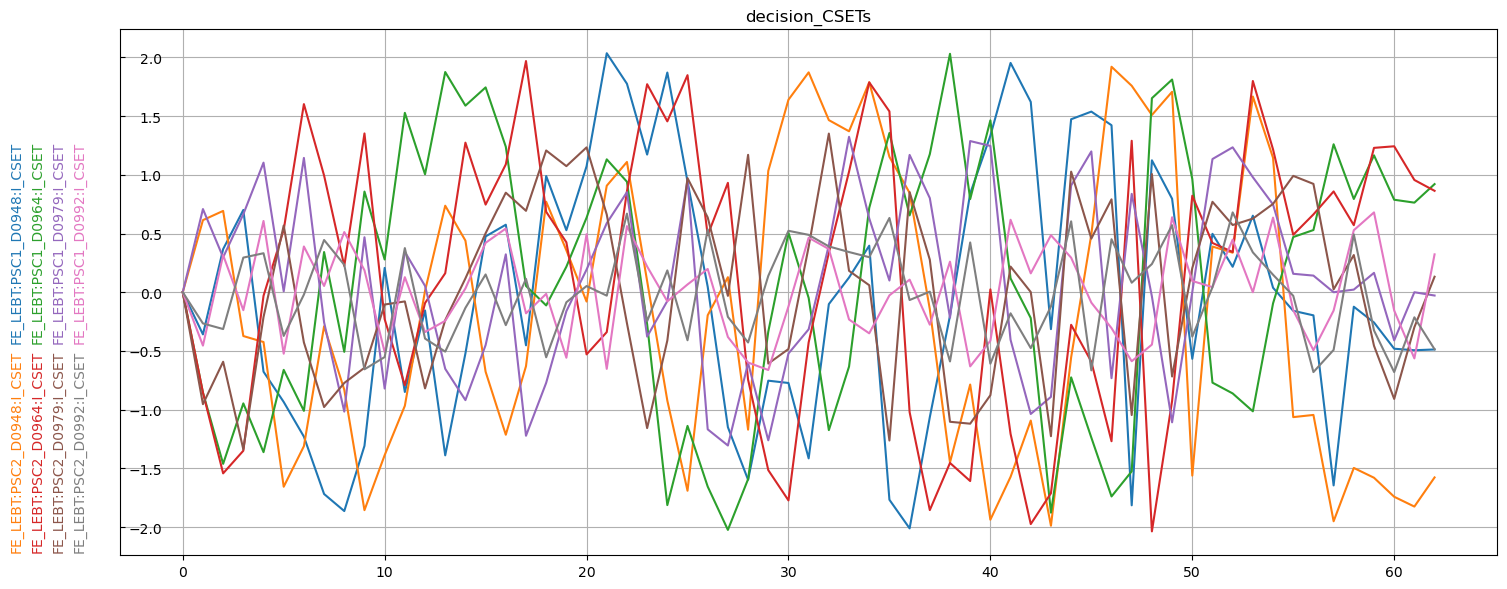

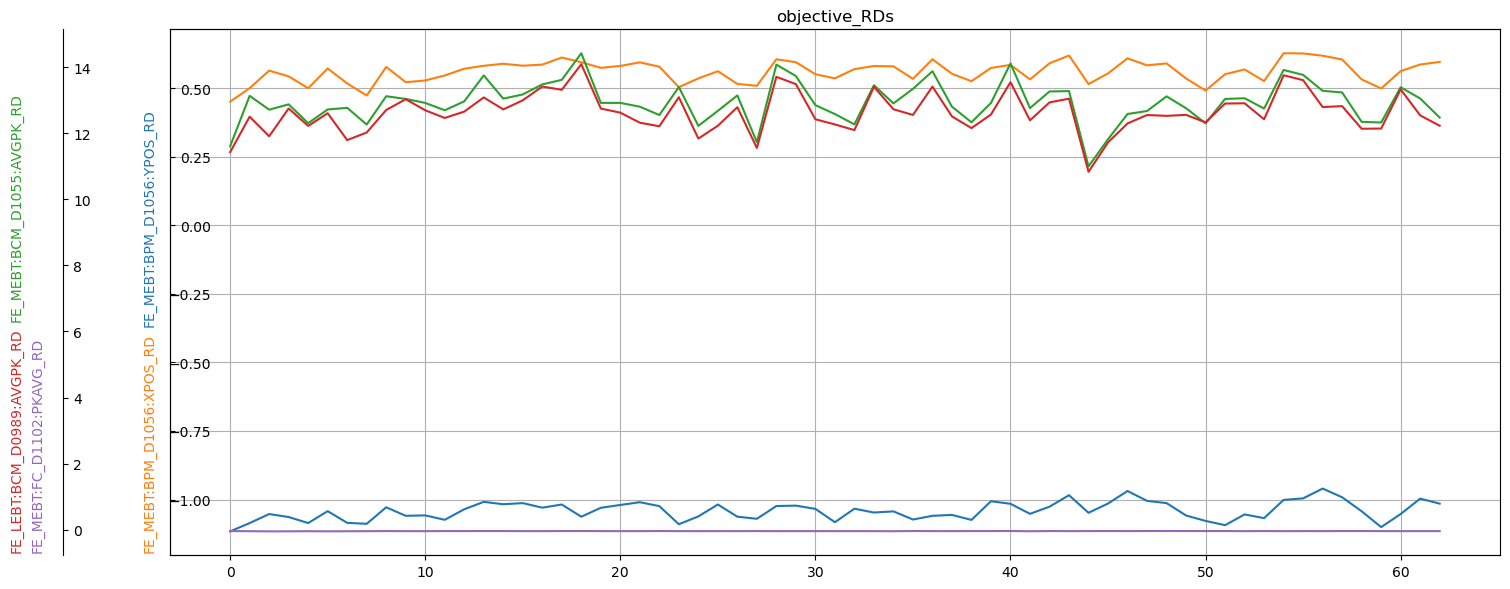

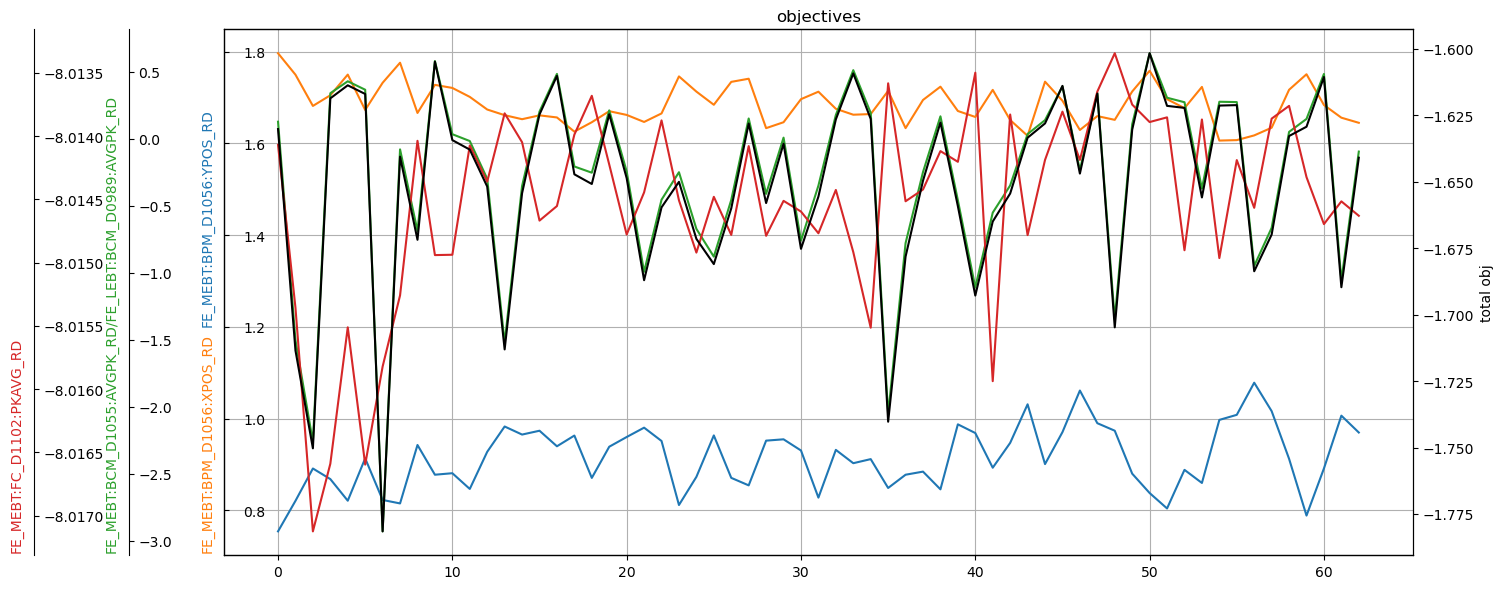

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%



In [18]:
# run optimizer
bo, X_pending, Y_pending_future = pyBO.runBO(
                                    obj_callbacks,  
                                    bounds=obj.decision_bounds,
                                    n_init=n_init,
                                    x0 = obj.x0,
                                    budget = n_init + 2*n_local_search,
                                    batch_size=1,
#                                     timeout = 2+objFuncs._global_machineIO._fetch_data_time_span,
                                    path="./log/",
                                    tag=fname+'_pyBO_history',
                                    write_log = False)
for f in callbacks:
    f.close()

### Fine Tune near current best

64


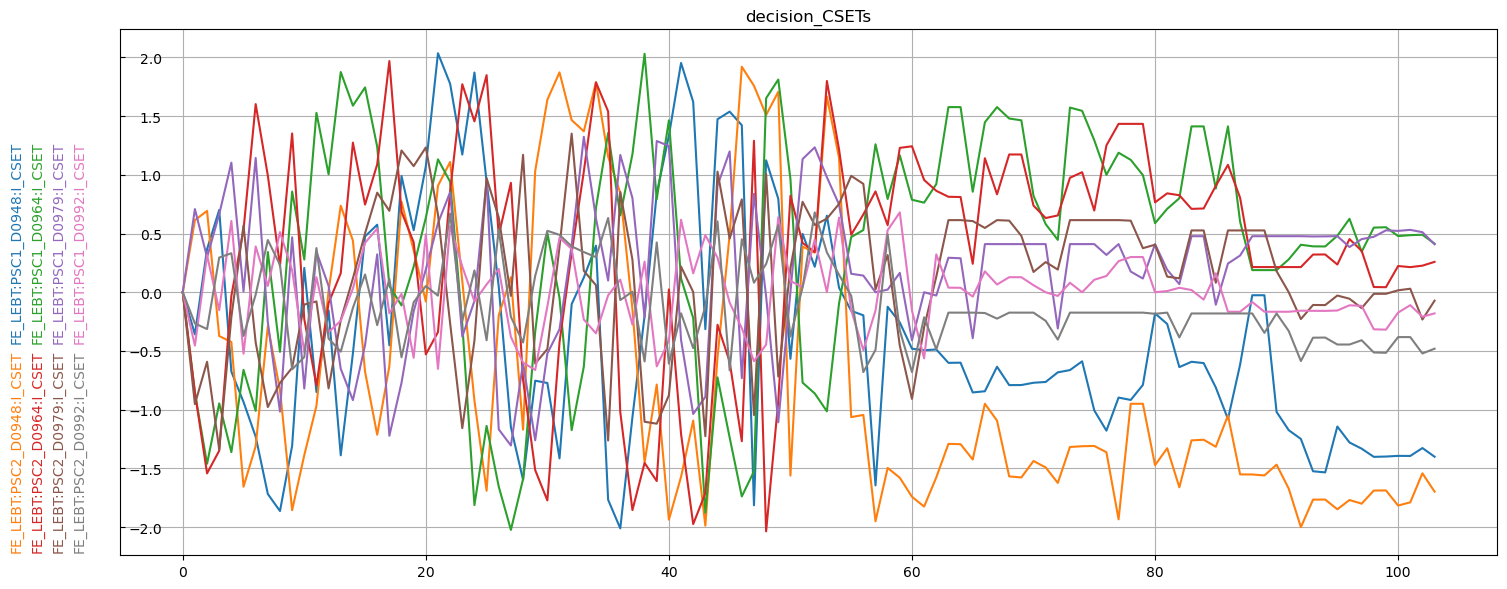

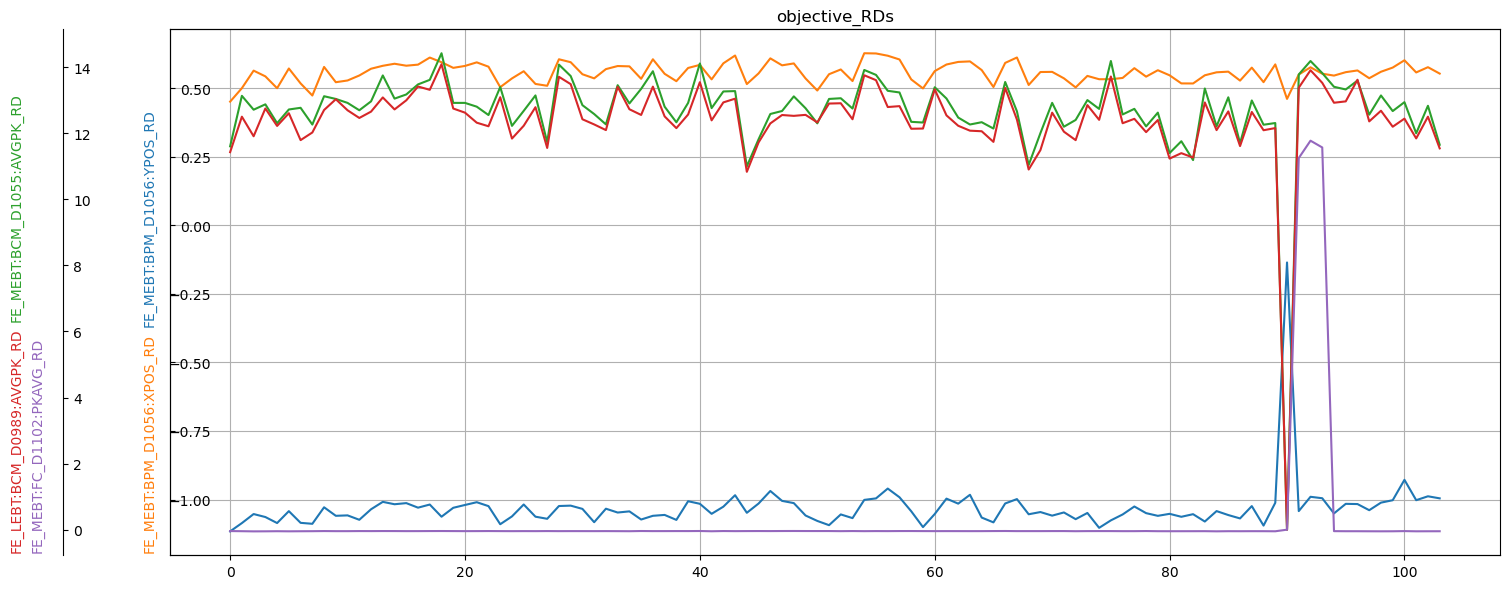

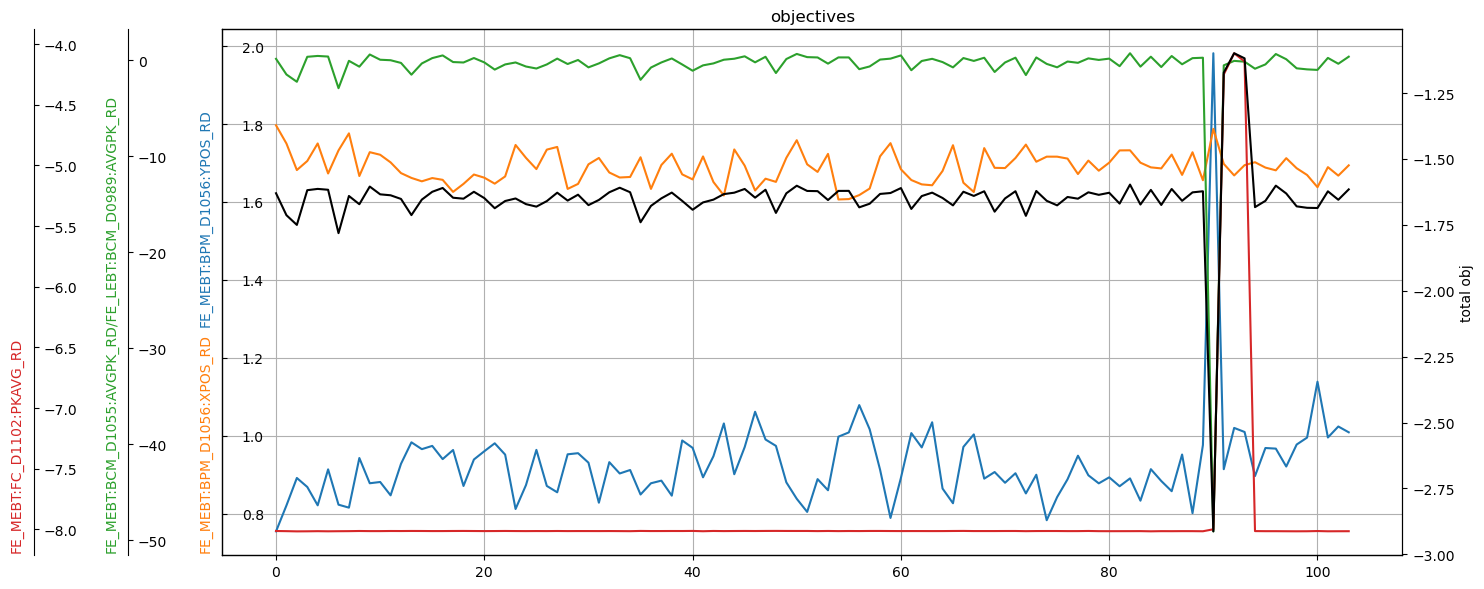

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

71
[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

78
[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

85
[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

92
[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

99
[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

106
[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

113
[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%



In [19]:
bounds_diff = obj.decision_bounds[:,1] - obj.decision_bounds[:,0]


while(len(bo.y)<n_budget):
    print(len(bo.y))
    x_best,y_best = bo.best_sofar()
    bounds_best = np.array(list(zip(x_best-0.15*bounds_diff, x_best+0.15*bounds_diff)))
    acquisition_func_args = {'beta':9}

    X_pending, Y_pending_future= bo.loop( 
                                    n_loop=n_local_search-1,  # number of additional optimization interation
                                    func_obj = obj_callbacks,
                                    bounds = bounds_best,
                                    acquisition_func_args = acquisition_func_args,
                                    X_pending = X_pending, 
                                    Y_pending_future = Y_pending_future,
                                    batch_size = 1,
                                    write_log = False,
                                    )
    
    acquisition_func_args = {'beta':1}

    X_pending, Y_pending_future= bo.loop( 
                                    n_loop=1,  # number of additional optimization interation
                                    func_obj = obj_callbacks,
                                    bounds = bounds_best,
                                    acquisition_func_args = acquisition_func_args,
                                    X_pending = X_pending, 
                                    Y_pending_future = Y_pending_future,
                                    batch_size = 1,
                                    write_log = False,
                                    )
    
x_best,y_best = bo.best_sofar()
bounds_best = np.array(list(zip(x_best-0.15*bounds_diff, x_best+0.15*bounds_diff)))
acquisition_func_args = {'beta':0.01}

X_pending, Y_pending_future= bo.loop( 
                                n_loop=1,  # number of additional optimization interation
                                func_obj = obj_callbacks,
                                bounds = bounds_best,
                                acquisition_func_args = acquisition_func_args,
                                X_pending = X_pending, 
                                Y_pending_future = Y_pending_future,
                                batch_size = 1,
                                write_log = False,
                                )
    
for f in callbacks:
    f.close()

[████████████████████████████████████████] 100%/100%



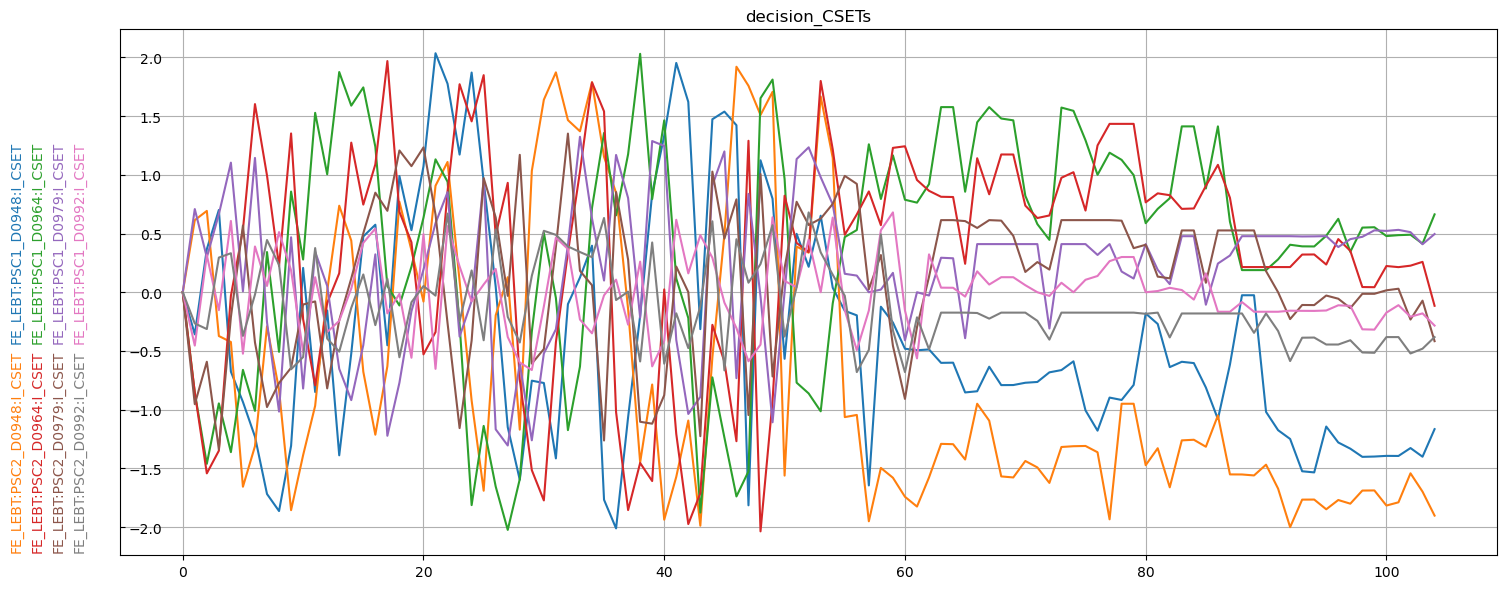

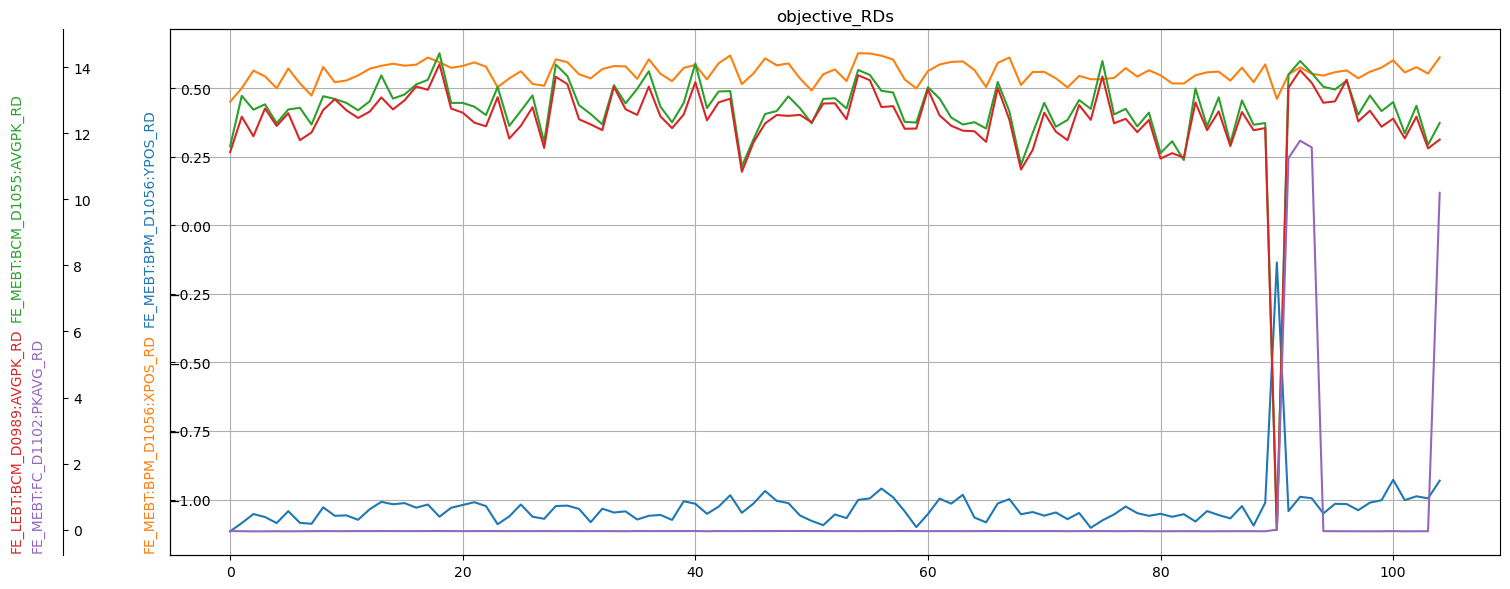

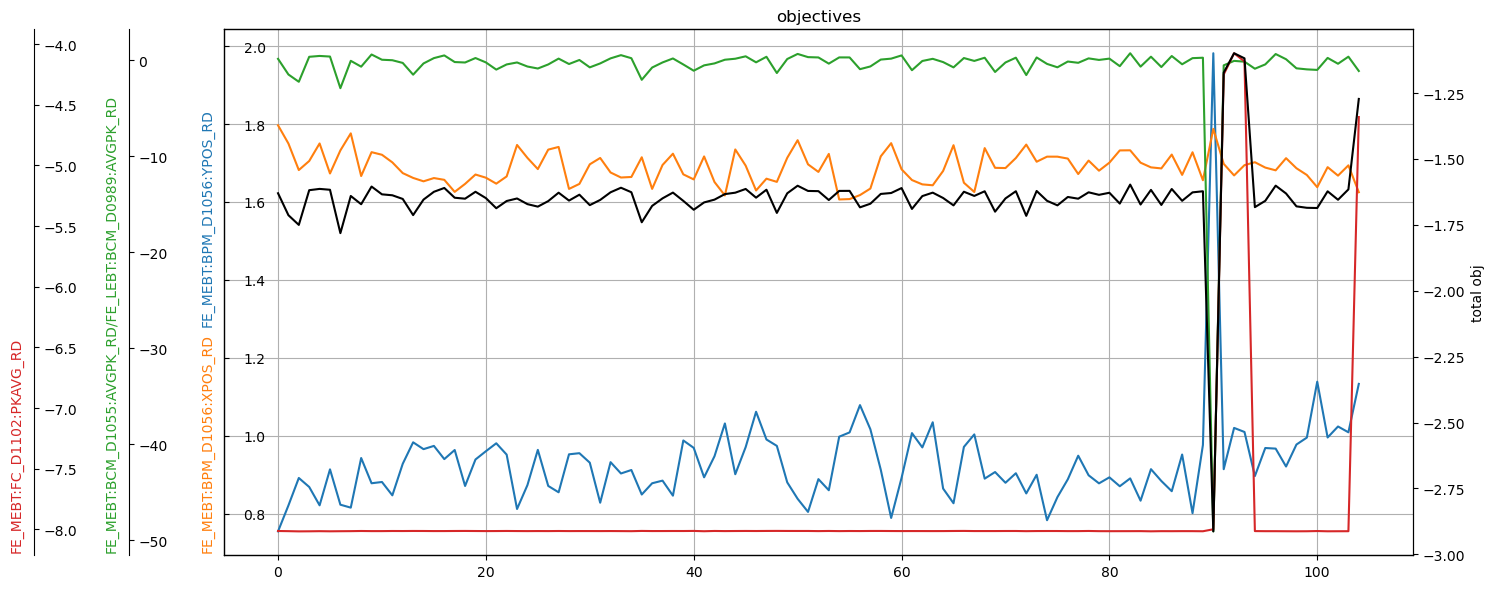

In [20]:
for i in range(1):

    x_best,y_best = bo.best_sofar()
    bounds_best = np.array(list(zip(x_best-0.15*bounds_diff, x_best+0.15*bounds_diff)))
    acquisition_func_args = {'beta':0.01}

    X_pending, Y_pending_future= bo.loop( 
                                    n_loop=1,  # number of additional optimization interation
                                    func_obj = obj_callbacks,
                                    bounds = bounds_best,
                                    acquisition_func_args = acquisition_func_args,
                                    X_pending = X_pending, 
                                    Y_pending_future = Y_pending_future,
                                    batch_size = 1,
                                    write_log = False,
                                    )
    
for f in callbacks:
    f.close()

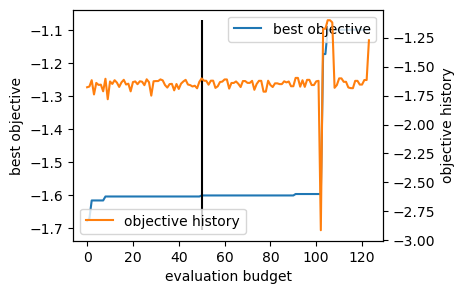

In [21]:
ax = bo.plot_obj_history()
ax.vlines(n_init,*ax.get_ylim(),color='k')

### set to best solution 

In [22]:
x_best,y_best_old = bo.best_sofar()
y_best_new = obj(x_best)
print(x_best,y_best_old[0],y_best_new)   # check if best solution objective value is consistent

[-1.24957453 -2.00076819  0.40444395  0.21441384  0.47738069 -0.22848935
 -0.15702752 -0.58590011] -1.0989984483192972 -1.2000658311230892


In [23]:
df = pd.DataFrame(obj.history['objective_RDs']['values'][-1], index=obj.history['objective_RDs']['names'])
df

,0
FE_MEBT:BPM_D1056:XPOS_RD,-0.969044
FE_MEBT:BPM_D1056:YPOS_RD,0.592699
FE_MEBT:BCM_D1055:AVGPK_RD,11.811278
FE_LEBT:BCM_D0989:AVGPK_RD,12.080923
FE_MEBT:FC_D1102:PKAVG_RD,10.207316


In [24]:
(df.loc["FE_MEBT:BCM_D1055:AVGPK_RD"]/df.loc["FE_LEBT:BCM_D0989:AVGPK_RD"]).values[0]

0.9776801061562884

In [25]:
obj.write_log(fname=os.path.join('./log',fname))

only .pkl file extension is accepted. saving to: ./log/20231218_2134[238U35][pyBO_TR][MEBT]FC1102.pkl


# change objective goal/norm/weights. 
##### Note that if an objective weight were zero previously, that objective cannot be added.
objFunc does not read nor record data corresponding to the zero weight

In [26]:
# objective_weight = { 
#     'FE_MEBT:BPM_D1056:XPOS_RD' : 1,     
#     'FE_MEBT:BPM_D1056:YPOS_RD' : 1,     
#     'FE_MEBT:BPM_D1056:PHASE_RD': 1., 
#     'FE_MEBT:BCM_D1055:AVGPK_RD/FE_LEBT:BCM_D0989:AVGPK_RD': 1,
#     'FE_MEBT:FC_D1102:PKAVG_RD': 2.,
#     }

# obj.update_objective(objective_weight=objective_weight)

# x = np.array(obj.history['decision_CSETs']['values'][:-2])
# y = np.array(obj.history['objectives']['total'])[:-2,None]
# bo.update_model(x=x,y=y)

# x_best,y_best = bo.best_sofar()
# print(x_best, y_best)

In [27]:
# acquisition_func_args = {'beta':9.}
# X_pending, Y_pending_future= bo.loop( 
#                             n_loop=16,  # number of additional optimization interation
#                             func_obj = obj_callbacks,
#                             bounds = obj.decision_bounds,
#                             acquisition_func_args = acquisition_func_args,
#                             X_pending = X_pending, 
#                             Y_pending_future = Y_pending_future,
#                             batch_size = 1,
#                             write_log = False,
#                             )



# acquisition_func_args = {'beta':0.01}
# X_pending, Y_pending_future= bo.loop( 
#                                 n_loop=2,  # number of additional optimization interation
#                                 func_obj = obj_callbacks,
#                                 bounds = obj.decision_bounds,
#                                 acquisition_func_args = acquisition_func_args,
#                                 X_pending = X_pending, 
#                                 Y_pending_future = Y_pending_future,
#                                 batch_size = 1,
#                                 write_log = False,
#                                 )

# for f in callbacks:
#     f.close()

In [28]:
# # local optimization near the best_solution
# bounds_diff = obj.decision_bounds[:,1] - obj.decision_bounds[:,0]
# for i in range(2):
#     x_best,y_best = bo.best_sofar()
#     bounds_best = np.array(list(zip(x_best-0.08*bounds_diff, x_best+0.08*bounds_diff)))
#     acquisition_func_args = {'beta':1}

#     X_pending, Y_pending_future= bo.loop( 
#                                     n_loop=3,  # number of additional optimization interation
#                                     func_obj = obj_callbacks,
#                                     bounds = bounds_best,
#                                     acquisition_func_args = acquisition_func_args,
#                                     X_pending = X_pending, 
#                                     Y_pending_future = Y_pending_future,
#                                     batch_size = 1,
#                                     write_log = False,
#                                     )
# for f in callbacks:
#     f.close()

In [29]:
# ax = bo.plot_obj_history()
# ax.vlines(n_init,*ax.get_ylim(),color='k')

In [30]:
# # set to best solution 
# x_best,y_best_old = bo.best_sofar()
# y_best_new = obj(x_best)
# print(x_best,y_best_old[0],y_best_new)   # check if best solution objective value is consistent

In [31]:
# obj.write_log(fname=os.path.join('./log',fname))

In [32]:
# df = pd.DataFrame(obj.history['objective_RDs']['values'][-1], index=obj.history['objective_RDs']['names'])
# df

In [33]:
# (df.loc["FE_MEBT:BCM_D1055:AVGPK_RD"]/df.loc["FE_LEBT:BCM_D0989:AVGPK_RD"]).values[0]

# Visualize Surrogate model

In [34]:
# fixed_values_for_each_dim = {2:x_best[2],3:x_best[3]}  # fix values to visualize high dim surrogate model
fixed_values_for_each_dim = None                         # do not fix values but project maximum. Can take long time to plot
batch_size = 1

starting projection plot...


KeyboardInterrupt: 

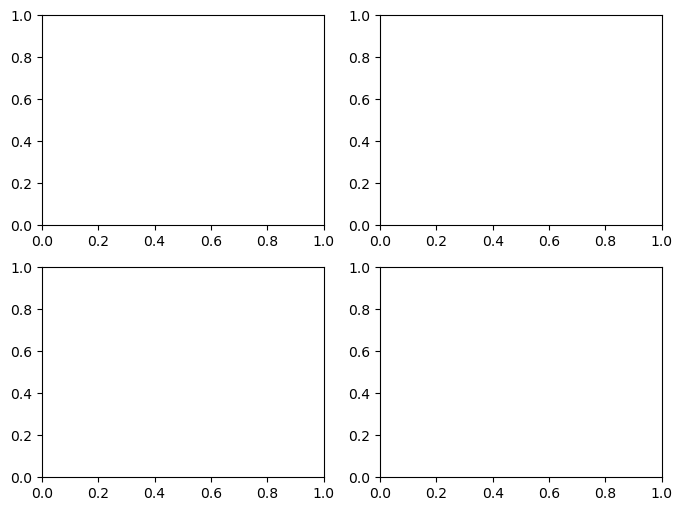

In [35]:
# plot surrogate mean model of the last epoch. Can take long time for decision dim >= 4

t0 = time.monotonic()
from math import ceil
nplot = int(0.5*len(obj.decision_CSETs))
nrow = ceil(0.5*nplot)
fig,ax = plt.subplots(nrow,2,figsize=(8,3*nrow))
for i in range(nrow):
    for j in range(2):
        n = 2*i+j
        if nrow>1:
            ax_ = ax[i,j]
        else:
            ax_ = ax[j]
        if n >= nplot:
            ax_.set_visible(False)
            break
        bo.plot_model_2D_projection(project_maximum=True,
                                    dim_xaxis = 2*n,
                                    dim_yaxis = 2*n+1,
                                    bounds = obj.decision_bounds,
                                    grid_ponits_each_dim = 16,
                                    fixed_values_for_each_dim=fixed_values_for_each_dim,
                                            fig=fig,ax=ax_);
        ax_.scatter(obj.x0[2*n],obj.x0[2*n+1],color='k',label='initial')
        ax_.scatter(x_best[2*n],x_best[2*n+1],color='r',label='optimum')
        ax_.set_xlabel(obj.decision_CSETs[2*n  ])
        ax_.set_ylabel(obj.decision_CSETs[2*n+1])
        ax_.legend()
fig.tight_layout()

    
print('time took: ',time.monotonic()-t0)